In [1]:
import glob
import tensorflow as tf

In [2]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
%matplotlib inline
%config InlineBackend.figure_format="retina"

In [3]:
# utility plotting functions
def __get_colorbar(im, ax) -> None:
    # hide x/y-axis ticks
    plt.setp(ax.get_xticklabels(), visible=False)
    plt.setp(ax.get_yticklabels(), visible=False)
    ax.tick_params(axis="both", which="both", length=0)
    # create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    plt.colorbar(im, cax=cax)

def plot_2d_field(data, ax, name):
    im = ax.imshow(data, cmap="viridis", origin="lower")
    ax.set_title(name);
    __get_colorbar(im, ax)

In [4]:
# shapes: (nvar, lat, lon)
LOWRES_SHAPE = (1, 16, 16)
HIRES_SHAPE = (1, 128, 128)
CONST_SHAPE = (3, 128, 128)

# Read the data back out.
def decode_fn(record_bytes):
    return tf.io.parse_single_example(
        # Data
        record_bytes,
        # Schema
        {
            # These are the features of your dataset like images, labels ...
            # Hi-res (constant) input features
            "X_hr": tf.io.FixedLenFeature(shape=(), dtype=tf.string),
            # Low-res input features
            "X_lr": tf.io.FixedLenFeature(shape=(), dtype=tf.string),
            # Hi-res target
            "Y": tf.io.FixedLenFeature(shape=(), dtype=tf.string),
        },
    )

In [5]:
# tfrecord files are sharded so we read them all at once using a glob
example_path = glob.glob("/scratch/TF-DATASETS/datasets/sr_dataset/1.0.0/sr_dataset-test.tfrecord*")

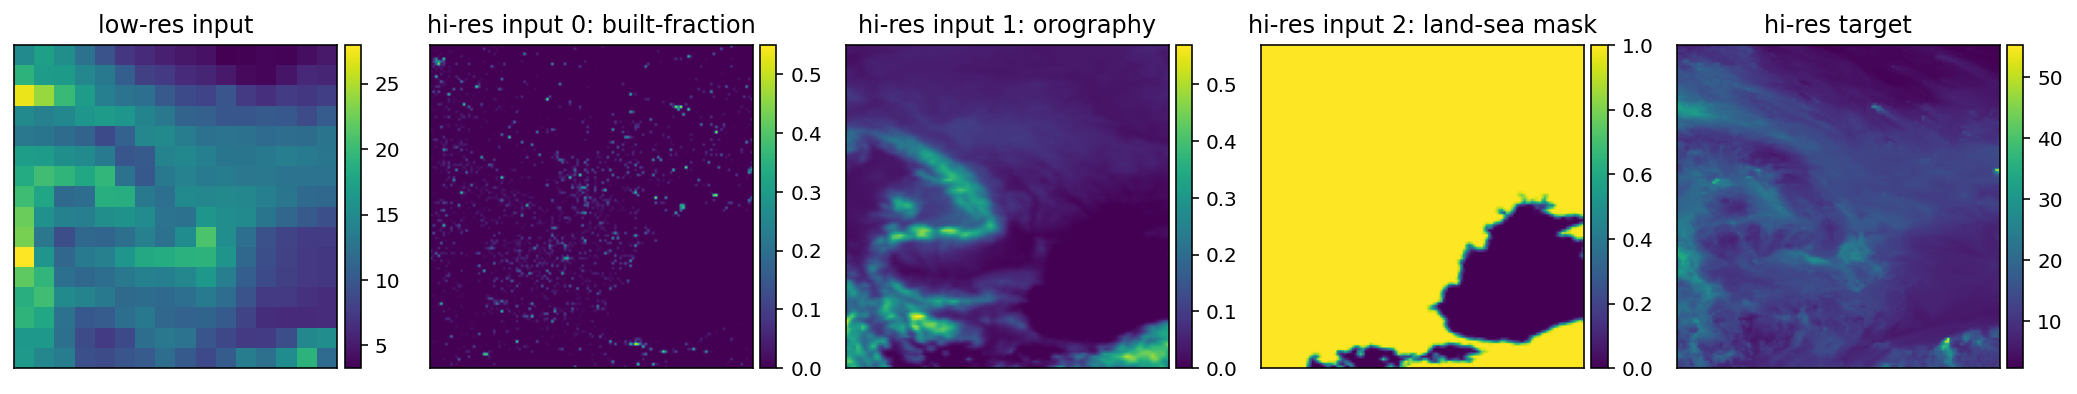

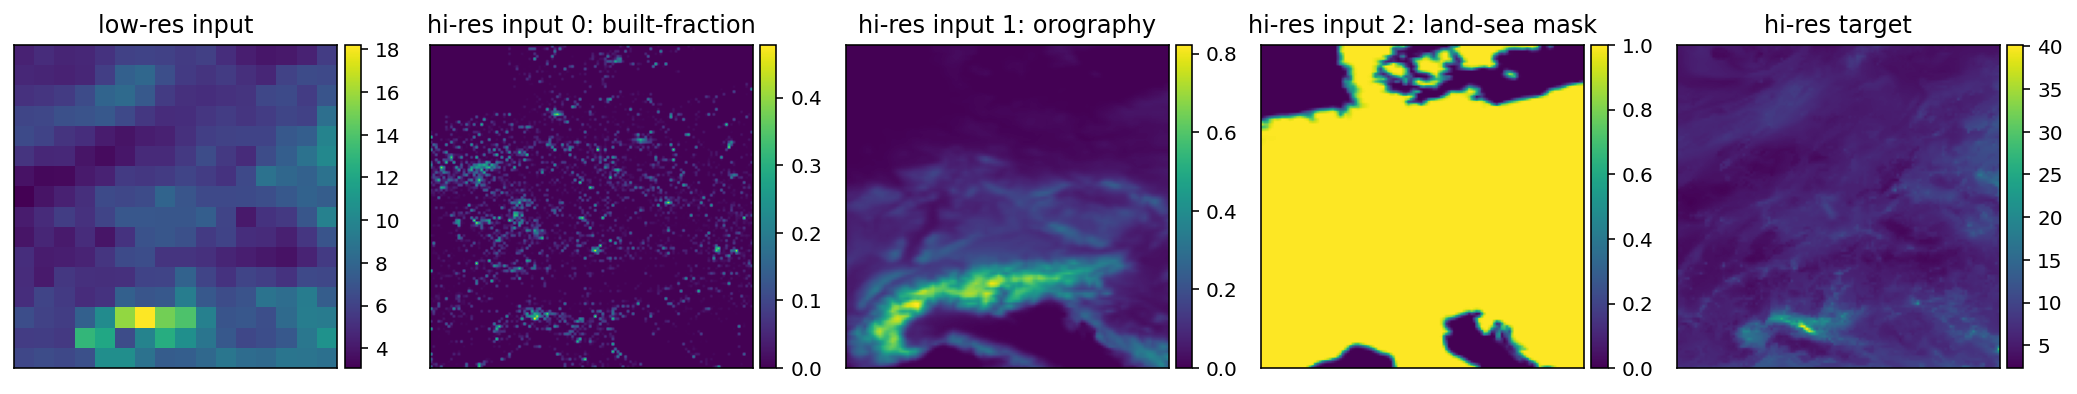

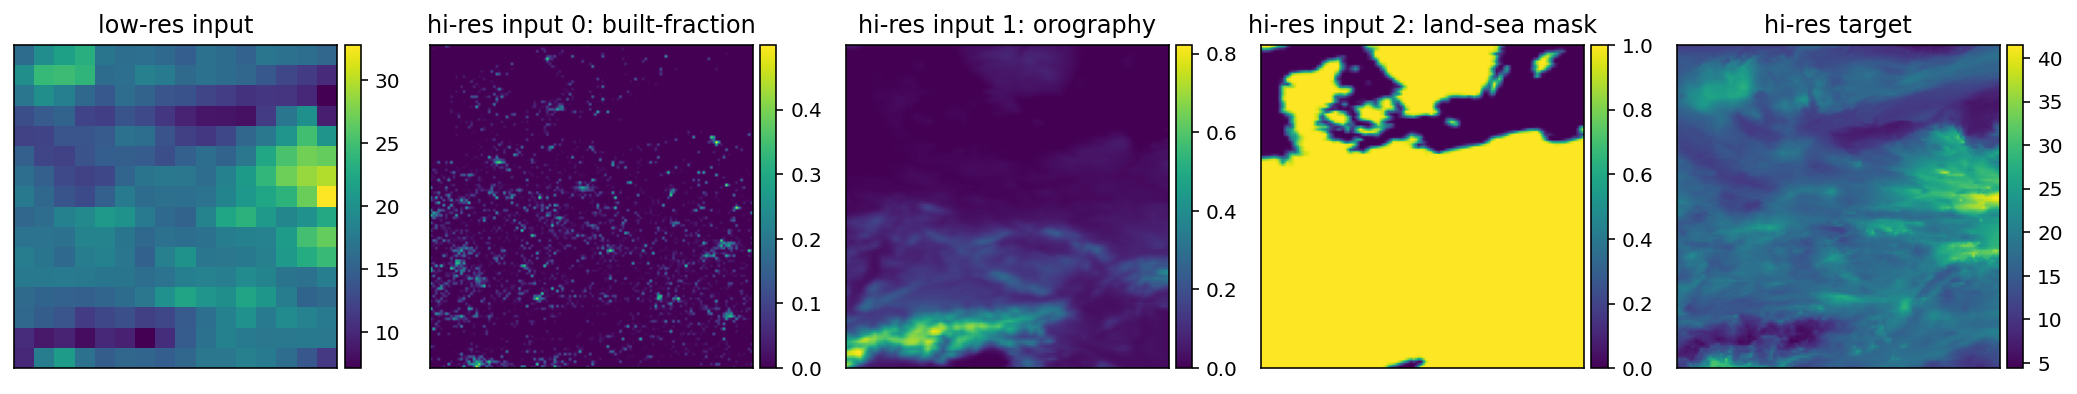

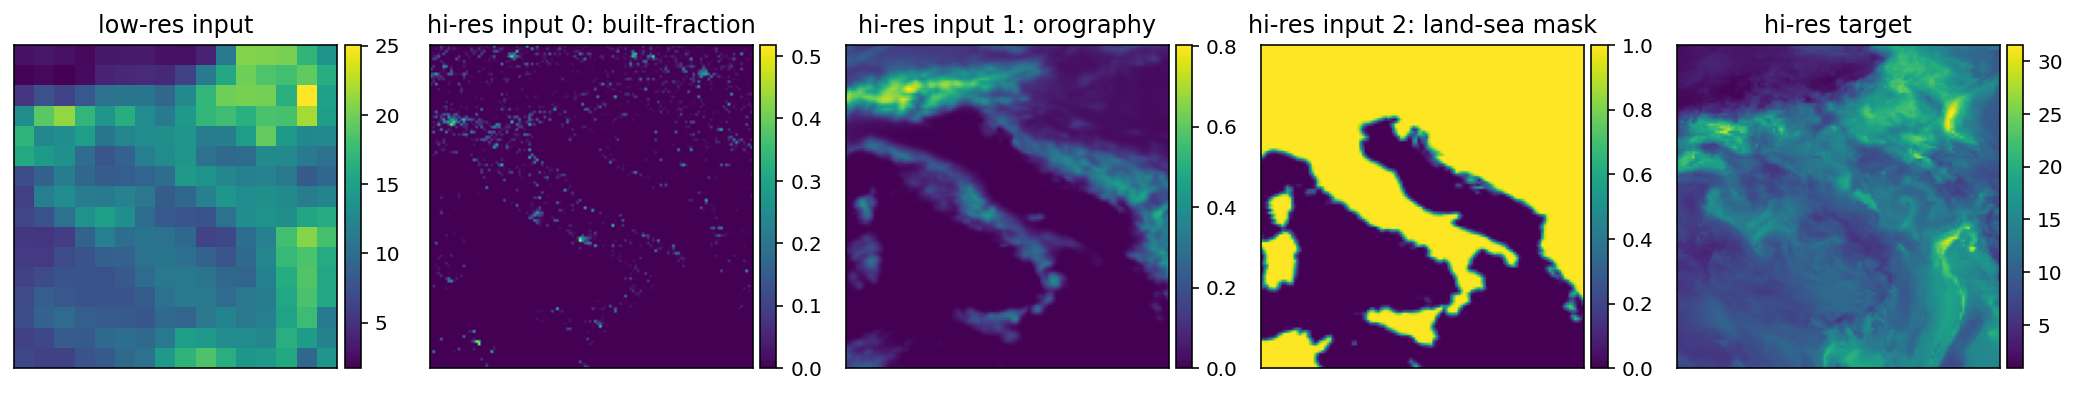

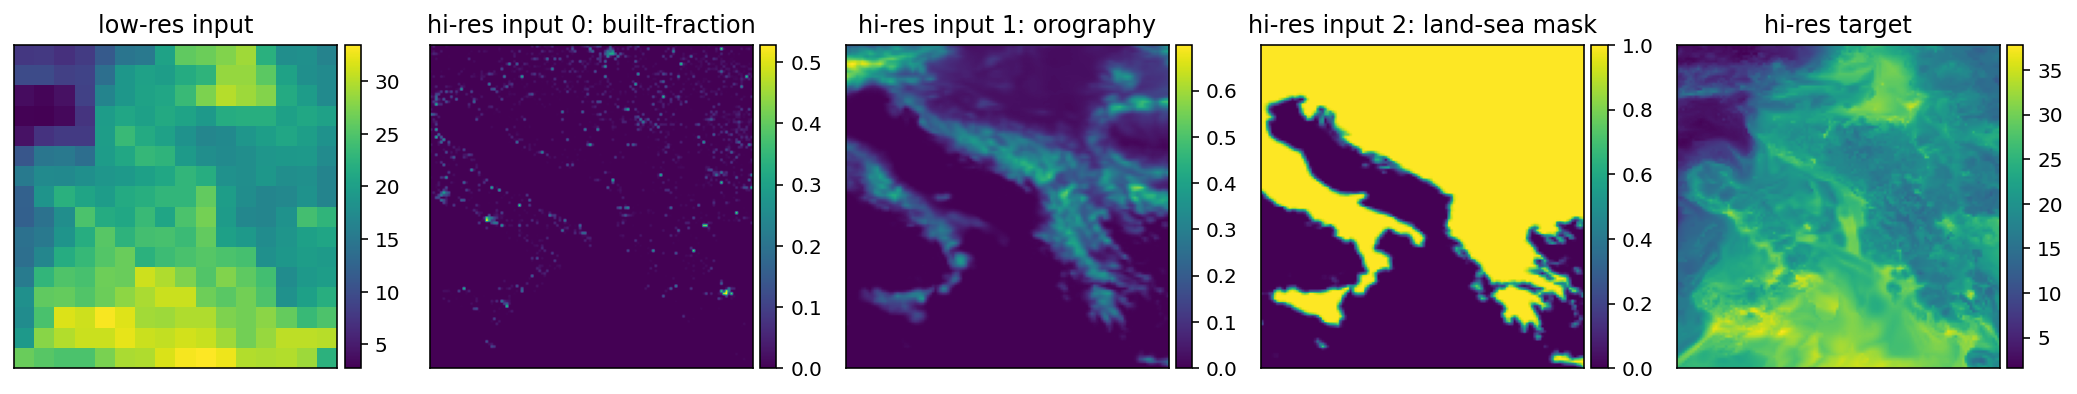

In [9]:
def decompress(batch_, compression_type: str = "ZLIB") -> tf.Tensor:
    """Decompress and decode a single batch or sample."""
    return tf.io.decode_raw(tf.io.decode_compressed(batch_, compression_type=compression_type), tf.float32)

hres_in_name = {
    0: "built-fraction",
    1: "orography",
    2: "land-sea mask",
}

for batch in tf.data.TFRecordDataset(example_path).map(decode_fn).take(5):
    x_lr = tf.reshape(decompress(batch["X_lr"]), LOWRES_SHAPE)
    x_hr = tf.reshape(decompress(batch["X_hr"]), CONST_SHAPE)
    y = tf.reshape(decompress(batch["Y"]), HIRES_SHAPE)
    
    n_plots = 5
    fig, ax = plt.subplots(1, n_plots, figsize=(18, 4))
    plot_2d_field(x_lr[0, ...], ax[0], "low-res input")
    for i in range(3):
        plot_2d_field(x_hr[i, ...], ax[i+1], f"hi-res input {i}: {hres_in_name[i]}")
    plot_2d_field(y[0, ...], ax[4], "hi-res target")